In [1]:
# install libraries
import influxdb_client
import pandas as pd
import secret
import sensor_data_functions
from weather_data_functions import get_current_weather, get_historical_weather
import matplotlib.pyplot as plt
import requests
from datetime import datetime

In [2]:
lookback = '24h'
generation_df, consumption_df = sensor_data_functions.get_sensor_data(lookback)
generation_df.head()

,power
datetime,
2023-12-14 19:05:00+00:00,0.081028
2023-12-14 19:05:01+00:00,0.080417
2023-12-14 19:05:02+00:00,0.082065
2023-12-14 19:05:03+00:00,0.080709
2023-12-14 19:05:04+00:00,0.080773


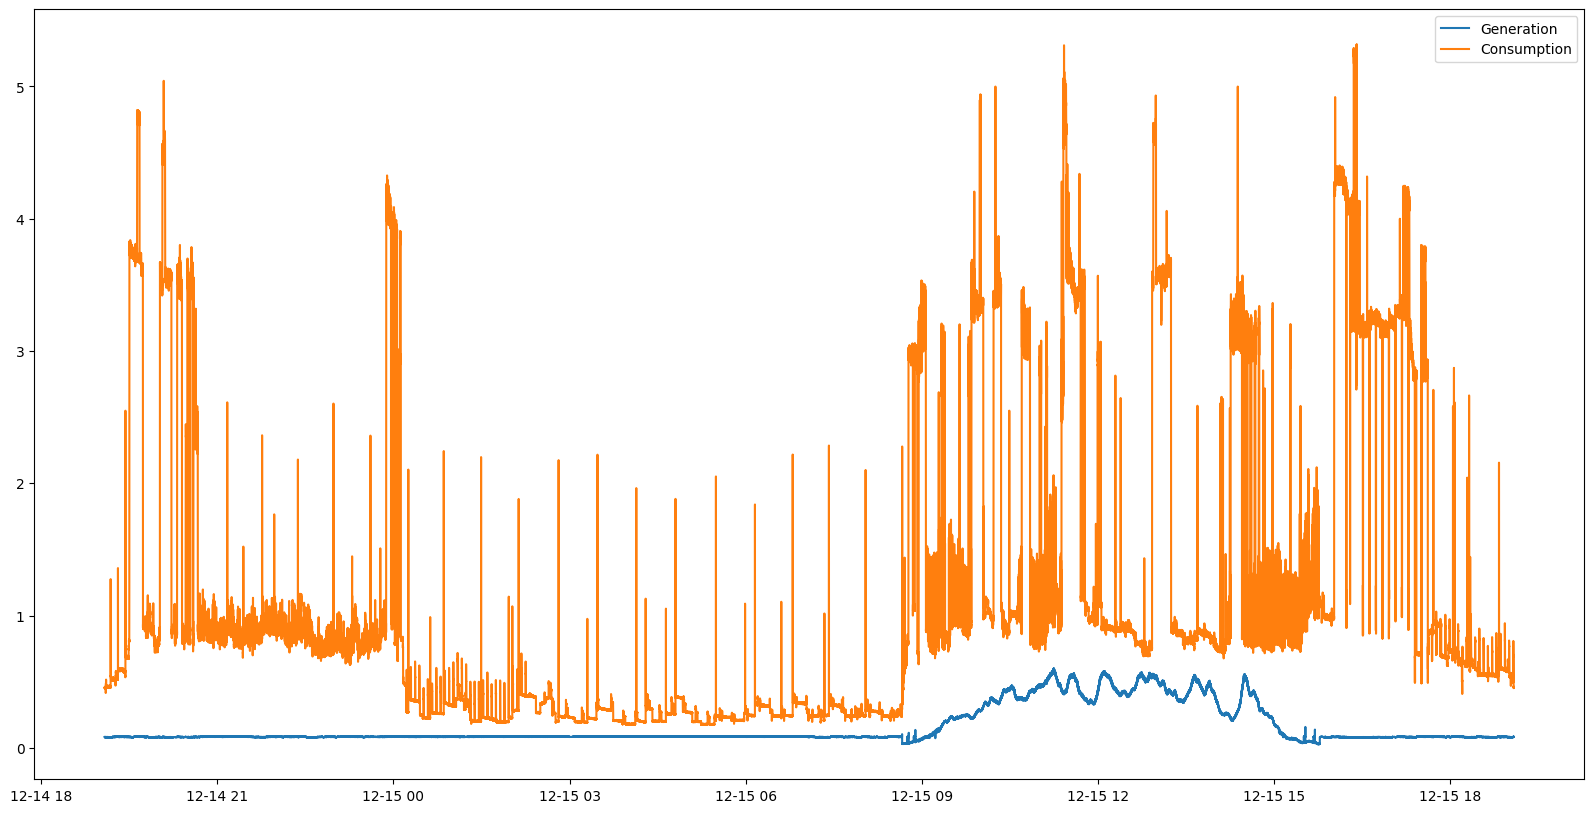

In [3]:
# plot both generation and consumption
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(generation_df.index, generation_df['power'], label='Generation')
ax.plot(consumption_df.index, consumption_df['power'], label='Consumption')
ax.legend()

In [4]:
postcode = 'WR7 4BU'
current_weather = get_current_weather(postcode)
current_weather

,last_updated_epoch,temp_c,temp_f,is_day,wind_mph,wind_kph,wind_degree,wind_dir,pressure_mb,pressure_in,...,humidity,cloud,feelslike_c,feelslike_f,vis_km,vis_miles,uv,gust_mph,gust_kph,condition
last_updated,,,,,,,,,,,,,,,,,,,,,
2023-12-15 19:00,1702666800,8.0,46.4,0,8.1,13.0,210,SSW,1037.0,30.62,...,87,25,5.9,42.5,10.0,6.0,1.0,16.0,25.7,Partly cloudy


In [5]:
postcode = 'WR7 4BU'
date_time = datetime(year=2023, month=12, day=14)

get_historical_weather(postcode, date_time)

,time_epoch,temp_c,temp_f,is_day,wind_mph,wind_kph,wind_degree,wind_dir,pressure_mb,pressure_in,...,will_it_rain,chance_of_rain,will_it_snow,chance_of_snow,vis_km,vis_miles,gust_mph,gust_kph,uv,condition
time,,,,,,,,,,,,,,,,,,,,,
2023-12-14 00:00,1702512000,2.1,35.8,0,4.0,6.5,288,WNW,1016.0,30.01,...,0,0,0,0,10.0,6.0,7.9,12.6,1.0,Cloudy
2023-12-14 01:00,1702515600,1.8,35.2,0,3.8,6.1,268,W,1017.0,30.02,...,0,0,0,0,10.0,6.0,7.5,12.0,1.0,Clear
2023-12-14 02:00,1702519200,2.0,35.6,0,4.7,7.6,257,WSW,1017.0,30.05,...,0,0,0,0,10.0,6.0,8.9,14.3,1.0,Overcast
2023-12-14 03:00,1702522800,2.3,36.2,0,4.5,7.2,222,SW,1017.0,30.04,...,0,0,0,0,10.0,6.0,8.3,13.3,1.0,Overcast
2023-12-14 04:00,1702526400,3.0,37.4,0,4.5,7.2,216,SW,1017.0,30.04,...,0,0,0,0,10.0,6.0,7.8,12.6,1.0,Overcast
2023-12-14 05:00,1702530000,3.3,38.0,0,4.7,7.6,212,SSW,1018.0,30.05,...,0,45,0,0,10.0,6.0,8.1,13.0,1.0,Patchy rain possible
2023-12-14 06:00,1702533600,3.6,38.6,0,5.1,8.3,194,SSW,1018.0,30.06,...,0,0,0,0,10.0,6.0,9.1,14.6,1.0,Overcast
2023-12-14 07:00,1702537200,3.9,39.1,0,5.8,9.4,189,S,1018.0,30.07,...,0,0,0,0,10.0,6.0,10.3,16.6,1.0,Overcast
2023-12-14 08:00,1702540800,4.3,39.8,0,6.5,10.4,193,SSW,1019.0,30.08,...,0,0,0,0,10.0,6.0,11.5,18.5,1.0,Overcast
